# Customer Lifetime Value Calculation
---
In this notebook we will use BG/NBD (Beta Geometric/Negative Binomial Distribution) model to calculate CLV (Customer Lifetime Value) calculation with the help of `lifetimes` package

`CLV = Expected No.of Transactions X Revenue per Transaction X Margin`

- Expected No.of Transactions will be calculated using `BG/NBD model`
- Revenue per Transaction will be calculated using `Gamma Gamma model`

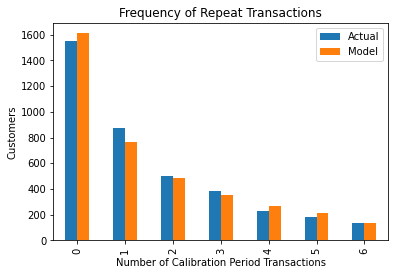

> ## Import Required Libraries

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes import GammaGammaFitter

> ## Import the Dataset

In [4]:
data = pd.read_excel('./Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data.shape

(541909, 8)

In [6]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

> ### Remove the time portion from the `InvoiceDate` feature 

In [12]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format = "%m/%d/%Y %H:%M").dt.date

In [13]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


> There are 135,000 missing values in the `CustomerID` feature, and since our analysis is based on customers, we will remove these missing values

In [14]:
data = data[pd.notnull(data['CustomerID'])]
data.shape

(406829, 8)

> Keeping the records with non negative value in `Quantity` feature

In [17]:
data = data[data['Quantity'] > 0]
data.shape

(397924, 8)

> Add a new feature dipicting total sales, and extracting only required features

In [18]:
data['TotalSales'] = data['Quantity'] * data['UnitPrice']
necessary_cols = ['CustomerID', 'InvoiceDate', 'TotalSales']
data = data[necessary_cols]
data.head()

,CustomerID,InvoiceDate,TotalSales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


> Print records pertaining unique `CustomerID`

In [21]:
print('No.of Unique CustomerIDs: ', data['CustomerID'].nunique())

No.of Unique CustomerIDs:  4339


> Check the last order date

In [22]:
last_order_date = data['InvoiceDate'].max()
print('Last order date: ', last_order_date)
print('----------------------------------------')
print(data[data['CustomerID'] == 12346])

Last order date:  2011-12-09
----------------------------------------
       CustomerID InvoiceDate  TotalSales
61619     12346.0  2011-01-18     77183.6


> Using built-in utility functions from `lifetimes` package to transform the transactional data (one row per purchase) into summary data (a frequency, recency, age, and monetary)

In [32]:
lf_data = summary_data_from_transaction_data(data, 'CustomerID', 'InvoiceDate', monetary_value_col = 'TotalSales', observation_period_end = last_order_date)
lf_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


> Create histogram to find out how many customers purchased item only once

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
-----------------------------------------------
Percentage of customers purchase the item only once:  35.7 %


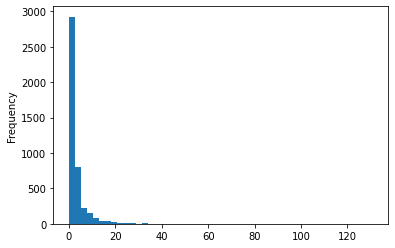

In [33]:
%matplotlib inline

lf_data['frequency'].plot(kind='hist', bins=50)
print(lf_data['frequency'].describe())
print('-----------------------------------------------')
one_time_buyers = round(sum(lf_data['frequency'] == 0) / float(len(lf_data)) * 100, 2)
print('Percentage of customers purchase the item only once: ', one_time_buyers, '%')

> ## Frequency/Recency Analysis using `BG/NBD` model

In [34]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef = 0)
bgf.fit(lf_data['frequency'], lf_data['recency'], lf_data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [35]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


> ## Visualizing Frequency/Recency matrix

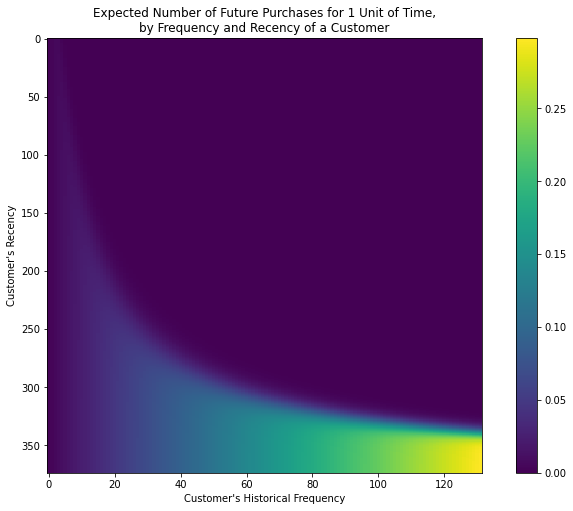

In [36]:
fig = plt.figure(figsize = (12, 8))
plot_frequency_recency_matrix(bgf)

> ## Predict if the customers are surely alive

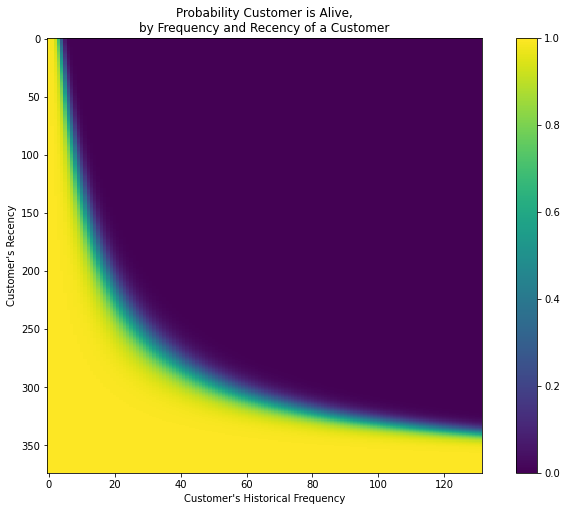

In [37]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize = (12, 8))
plot_probability_alive_matrix(bgf)

> ## Predict future transaction in next 10 days i.e. top 10 customers that the model expects them to make purchases in the next 10 days, based on historical data

In [39]:
t = 10
lf_data['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, lf_data['frequency'], lf_data['recency'], lf_data['T']), 2)
lf_data.sort_values(by = 'pred_num_txn', ascending=False).reset_index().head(10)

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,14911.0,131.0,372.0,373.0,1093.661679,2.98
1,12748.0,113.0,373.0,373.0,298.360885,2.58
2,17841.0,111.0,372.0,373.0,364.452162,2.53
3,15311.0,89.0,373.0,373.0,677.729438,2.03
4,14606.0,88.0,372.0,373.0,135.890114,2.01
5,12971.0,70.0,369.0,372.0,159.211286,1.61
6,13089.0,65.0,367.0,369.0,893.714308,1.50
7,14527.0,53.0,367.0,369.0,155.016415,1.23
8,13798.0,52.0,371.0,372.0,706.650962,1.20
9,16422.0,47.0,352.0,369.0,702.472340,1.09


> ## Assessing the model fit

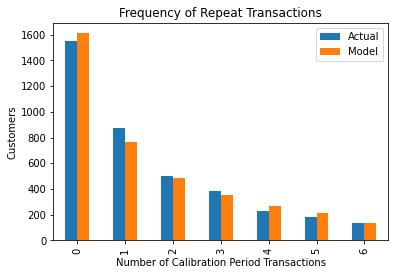

In [40]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf)

> ## Customer's future transaction prediction for next 10 days

> `OBSERVATION`: Our model predicts that customer `14911`'s future transaction is appx 3 in 10 days

In [41]:
t = 10
individual = lf_data.loc[14911]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

2.9830238639020674

> ## Check if there is correlation between monetary value and frequency in order to use `gamma gamma model` for `CLV` calculation

In [42]:
lf_data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.046161
frequency,0.046161,1.000000


> ## Shortlist customers who had at least one repeat purchase with the company

In [43]:
shortlisted_customers = lf_data[lf_data['frequency'] > 0]
print(shortlisted_customers.head().reset_index())
print('--------------------------------------------------')
print('The number of Returning Customers are: ', len(shortlisted_customers))

   CustomerID  frequency  recency      T  monetary_value  pred_num_txn
0     12347.0        6.0    365.0  367.0      599.701667          0.16
1     12348.0        3.0    283.0  358.0      301.480000          0.09
2     12352.0        6.0    260.0  296.0      368.256667          0.19
3     12356.0        2.0    303.0  325.0      269.905000          0.07
4     12358.0        1.0    149.0  150.0      683.200000          0.08
--------------------------------------------------
The number of Returning Customers are:  2790


> ## Train `gamma-gamma` model by taking into account the monetary value

In [44]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'], shortlisted_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


> ## After applying `Gamma Gamma` model, now we can estimate average transaction value for each customer

In [45]:
print(ggf.conditional_expected_average_profit(lf_data['frequency'], lf_data['monetary_value']).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64


In [46]:
lf_data['pred_txn_value'] = round(ggf.conditional_expected_average_profit(lf_data['frequency'], lf_data['monetary_value']), 2)
lf_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,12346.0,0.0,0.0,325.0,0.000000,0.02,416.92
1,12347.0,6.0,365.0,367.0,599.701667,0.16,569.99
2,12348.0,3.0,283.0,358.0,301.480000,0.09,333.76
3,12349.0,0.0,0.0,18.0,0.000000,0.10,416.92
4,12350.0,0.0,0.0,310.0,0.000000,0.02,416.92


In [47]:
lf_data['CLV'] = round(ggf.customer_lifetime_value(bgf, # the model to use to predict the no.of future transactions
                                                   lf_data['frequency'],
                                                   lf_data['recency'],
                                                   lf_data['T'],
                                                   lf_data['monetary_value'],
                                                   time = 12, # months
                                                   discount_rate = 0.01 # monthly discount rate ~ 12.7% annually
                                                   ), 2)
lf_data.drop(lf_data.iloc[:, 0:6], inplace=True, axis=1)
lf_data.sort_values(by = 'CLV', ascending=False).reset_index().head(10)

,CustomerID,CLV
0,14646.0,222128.93
1,18102.0,178895.33
2,16446.0,175531.47
3,17450.0,147476.62
4,14096.0,127589.20
5,14911.0,109442.13
6,12415.0,96290.23
7,14156.0,89410.33
8,17511.0,67660.41
9,16029.0,58729.62
